In [2]:
from isr_psych_models import MultiTrialSEM, primacy_model
import numpy as np
from matplotlib import pyplot as plt

In [3]:
class ordinal_positional_model(MultiTrialSEM, primacy_model):
    
    def __init__(self, SEM_params, PM_params, EM_threshold):

        MultiTrialSEM.__init__(self, param_dict=SEM_params)
        primacy_model.__init__(self, params_dict=PM_params)
        self.EM_threshold = EM_threshold
        self.num_EM_recalls = 0
        self.group_size = self.list_length # ignoring grouping effects by setting group size to list length

    def list_presentation_SEM_PM(self, items):

        self.list_presentation(list_length=self.list_length, group_size=self.group_size, items=items)
        self.present_list(items)

    def recall_list_SEM_PM(self):

        for i in range(self.list_length):

            # add selection noise
            item_act_noisy = self.item_activations + np.random.default_rng().normal(0, self.N, self.vocab_size_PM)

            # retrieve strongest activated item 
            selected_item = np.argmax(item_act_noisy)
            selected_item_act = np.max(item_act_noisy)    

            # add noise to selected item before comparing to output threshold 
            selected_item_act += np.random.default_rng().normal(0, self.M, 1)[0]

            # check if activation of selected item is greater than the threshold
            # if not, cue SEM
            if selected_item_act >= self.EM_threshold:
                # run SEM recall method to decay context and phonological token and suppress item 
                _ = self.recall_selection(i+1, i+1, recalled_item=selected_item)
            else:
                self.num_EM_recalls += 1
                selected_item = self.recall_selection(i+1, i+1)

            # set activation of selected item to 0 to model response suppression 
            self.item_activations[selected_item] = 0 
            self.activation_dynamics(recall_mode=True, item_inputs=np.zeros(self.vocab_size_PM))

    def simulate_lists_SEM_PM(self, num_trials):

        self.presented_list_storage = np.zeros((num_trials, self.list_length))
        self.recalled_list_storage = np.zeros((num_trials, self.list_length))

        for i in range(num_trials):

            if i % 2 == 0:
                vocab = np.arange(0,6,1)
            else:
                vocab = np.arange(6,12,1)

            current_list = np.random.default_rng().choice(vocab, self.list_length, replace=False)

            self.presented_list_storage[i] = current_list

            self.list_presentation_SEM_PM(current_list)
            self.recall_list_SEM_PM()

            self.recalled_list_storage[i] = self.recalled_list

        self.compute_errors_fig3(num_trials)

    def compute_errors_fig3(self, num_trials):

        self.frac_errors_list = []
        self.frac_omissions_list = []
        
        for l in range(self.list_length):

            presented_items_pos_l = self.presented_list_storage[:, l]
            recalled_items_pos_l = self.recalled_list_storage[:, l]
            
            frac_errors = np.round(1- np.argwhere(recalled_items_pos_l==presented_items_pos_l).shape[0] / num_trials,2)
            frac_omissions = np.argwhere(recalled_items_pos_l==-1).shape[0] / num_trials
            self.frac_errors_list.append(frac_errors)
            self.frac_omissions_list.append(frac_omissions)

In [4]:
params_SEM = {'s0': 1.0, 'e0': 0.60, 'S':0.8 , 'E': 0.48, 'G_c': 0.06, 'G_p':0.0, 'R_s': 0.50, 
                        'R_p': 0.20, 'T_o': 0.35, 'E_c': 0.98, 'E_l': 1.0, 'C_p': 1, 'C_d': 0, 'C_r': 1, 'C_i':36, 'C_a': 5, 'A_p':0,
                        'P_s':1, 'P_d':0, 'vocab_size_SM':12, 'max_tokens':30}

params_dict_PM = {'P':11.5, 'D':0.27, 'T':0.49, 'M':0.74, 'N':0.23, 'vocab_size_PM':12, 'input_strength':50, 
                    'item_presentation_rate':0.4, 'blank':0.1, 'R': 4, 
                    'list_length':6, 'output_time': 0.5, 'dt':0.005}



# manipulate inter-trial interval lengths
C_i_arr = [0, 4, 16, 36]
num_trials = 1000

perf_c_i_SEM = []
intrusions_c_i_SEM = []
immediate_intrusions_c_i_SEM = []
output_protrusions_c_i_SEM = []

perf_c_i_odm = []
intrusions_c_i_odm= []
immediate_intrusions_c_i_odm = []
output_protrusions_c_i_odm = []

for c_i in C_i_arr:
    params_SEM['C_i'] = c_i
    SEM = ordinal_positional_model(params_SEM, params_dict_PM, EM_threshold=100)
    odm = ordinal_positional_model(params_SEM, params_dict_PM, EM_threshold=1.0)
    SEM.simulate_lists_SEM_PM(num_trials)
    odm.simulate_lists_SEM_PM(num_trials)
    perf_c_i_SEM.append(SEM.frac_errors_list)
    intrusions_c_i_SEM.append(SEM.num_intrusions)
    output_protrusions_c_i_SEM.append(SEM.num_output_protrusions)
    perf_c_i_odm.append(odm.frac_errors_list)
    intrusions_c_i_odm.append(odm.num_intrusions)
    output_protrusions_c_i_odm.append(odm.num_output_protrusions)

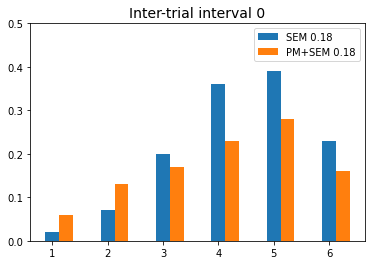

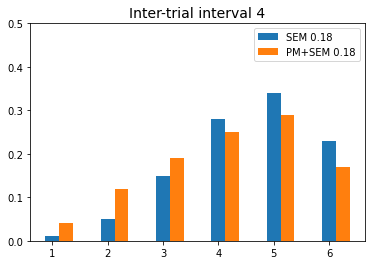

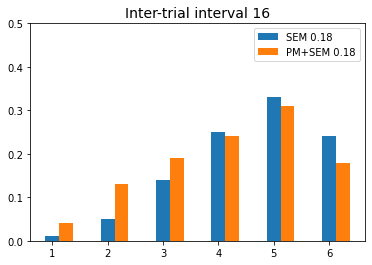

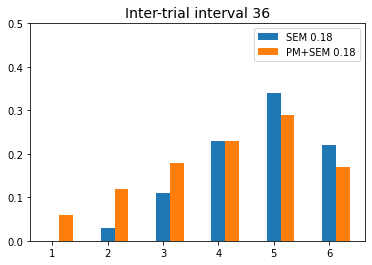

In [7]:
for C_i, perf_odm, perf_sem in zip(C_i_arr, perf_c_i_odm, perf_c_i_SEM):
    
    mean_perf_sem = np.round(np.mean(perf_sem),2)
    mean_perf_odm = np.round(np.mean(perf_odm),2)
    plt.bar(np.arange(1,7,1), perf_sem, width=0.25, label=f'SEM {mean_perf_sem}')
    plt.bar(np.arange(1.25,7.25,1), perf_odm, width=0.25, label=f"PM+SEM {mean_perf_odm}")
    plt.legend()
    plt.ylim(0,.5)
    plt.title(f'Inter-trial interval {C_i}', fontsize=14)
    plt.show()

In [12]:
perf_c_i_odm

[[0.05, 0.13, 0.18, 0.23, 0.27, 0.17],
 [0.06, 0.15, 0.2, 0.24, 0.28, 0.16],
 [0.05, 0.12, 0.17, 0.25, 0.31, 0.17],
 [0.06, 0.13, 0.18, 0.24, 0.28, 0.17]]

<h3> Short inter-trial interval </h3> 
Fraction of errors across serial positions: 0.06, 0.14, 0.2, 0.26, 0.32, 0.28 

Number of immediate intrusions: 898  

Number of protrusions: 193 

Number of protrusions expected by chance: 149.6




<h3> Long inter-trial interval </h3> 

Fraction of errors across serial positions: 0.06, 0.14, 0.19, 0.24, 0.31, 0.26 

Number of immediate intrusions: 70 

Number of protrusions: 11 

Number of protrusions expected by chance: 11.6





